<a href="https://colab.research.google.com/github/ddopazo92/Introduccion_datascience_diego_dopazo/blob/main/ProyectoFinal_ParteI%2BDopazo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract: Modelado Predictivo del Éxito en Videojuegos mediante Machine Learning

- Contexto: La industria de videojuegos depende críticamente del equilibrio entre calidad percibida y decisiones estratégicas de desarrollo y publicación. Nintendo, Sony y otras compañías líderes representan casos de estudio ideales debido a sus distintos enfoques de negocio y recepción en el mercado.

- Objetivo: Desarrollar un modelo predictivo que identifique los determinantes clave del éxito comercial en videojuegos, analizando la interacción entre calidad percibida por los usuarios y la critica, la plataformay el género.

Metodología: Utilizando un dataset de más de 16,000 videojuegos, implementamos un enfoque multimodal que combina:

- Análisis de ventas globales y regionales

- Evaluación comparativa de algoritmos: Random Forest, XGBoost y Regresión Logística

- Integración de métricas de los criticos (Puntuacion de la critica) y de los usuarios (Puntuacion del usaurio)

Hipótesis Principales:

 - Hipótesis de Calidad Percibida: Las puntuaciones de críticos y usuarios determinan significativamente el éxito comercial

 - Hipótesis de Plataforma-Género: Ciertas combinaciones plataforma-género maximizan el potencial de ventas

 - Hipótesis Regional: Las preferencias de género varían sustancialmente entre regiones (NA/EU/JP)

Variables Clave:

 - Objetivo: Global_Sales (éxito comercial)

 - Predictores: puntuacion criticos, puntuacion usuario, plataforma, genero, publicador, año_de_lanzamiento

 - Métricas: Ventas por región, ratings, datos temporales



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Configurar estilo
plt.style.use('default')
sns.set_palette("pastel")

# 1. Crear datos
np.random.seed(42)
n = 500

datos = {
    'criticos': np.random.normal(75, 15, n),
    'usuarios': np.random.normal(7.5, 1.5, n),
    'plataforma': np.random.choice(['PC', 'PlayStation', 'Xbox', 'Nintendo'], n, p=[0.3, 0.25, 0.25, 0.2]),
    'genero': np.random.choice(['Acción', 'RPG', 'Aventura', 'Shooter', 'Deportes'], n, p=[0.25, 0.2, 0.2, 0.25, 0.1]),
}

df = pd.DataFrame(datos)

# Calcular ventas y éxito (Nintendo tiene bonus para géneros familiares/aventura)
df['ventas'] = (
    df['criticos'] * 0.4 +
    df['usuarios'] * 8 +
    (df['plataforma'] == 'Nintendo') * 3 +
    (df['genero'].isin(['Aventura', 'RPG'])) * 2 +  # Nintendo se beneficia más de Aventura/RPG
    np.random.normal(0, 3, n)
)

umbral = df['ventas'].quantile(0.70)
df['exito'] = (df['ventas'] > umbral).astype(int)

print("=== DATOS DEL ANÁLISIS ===")
print(f"Total juegos: {len(df)}")
print(f"Umbral éxito: {umbral:.1f} millones")
print(f"Juegos exitosos: {df['exito'].sum()} ({df['exito'].mean()*100:.1f}%)")



=== DATOS DEL ANÁLISIS ===
Total juegos: 500
Umbral éxito: 97.7 millones
Juegos exitosos: 150 (30.0%)


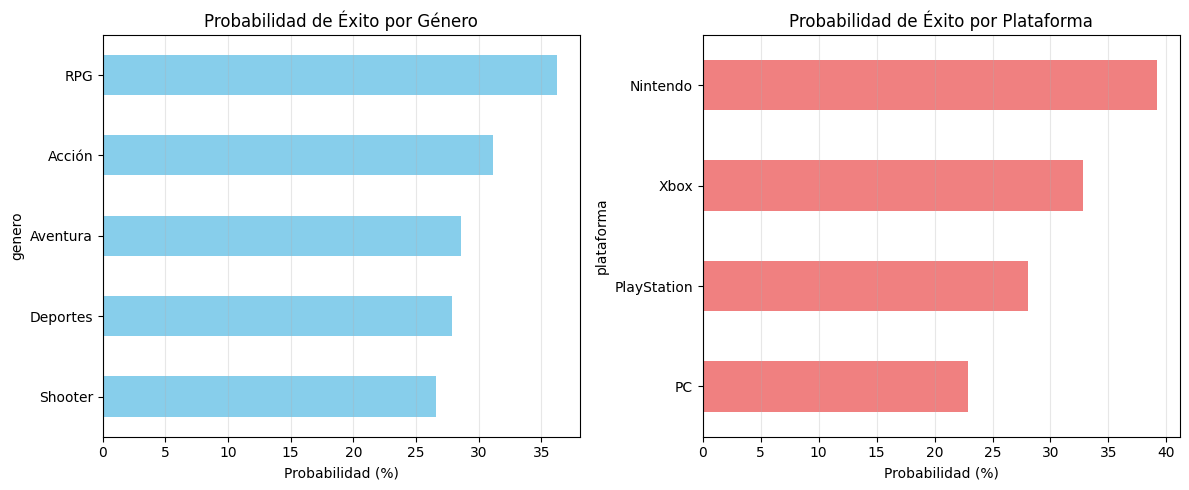

In [ ]:
# 2. Gráfico 1: Probabilidad de éxito por género y plataforma
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
exito_genero = df.groupby('genero')['exito'].mean() * 100
exito_genero.sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title('Probabilidad de Éxito por Género')
plt.xlabel('Probabilidad (%)')
plt.grid(axis='x', alpha=0.3)

plt.subplot(1, 2, 2)
exito_plataforma = df.groupby('plataforma')['exito'].mean() * 100
exito_plataforma.sort_values(ascending=True).plot(kind='barh', color='lightcoral')
plt.title('Probabilidad de Éxito por Plataforma')
plt.xlabel('Probabilidad (%)')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


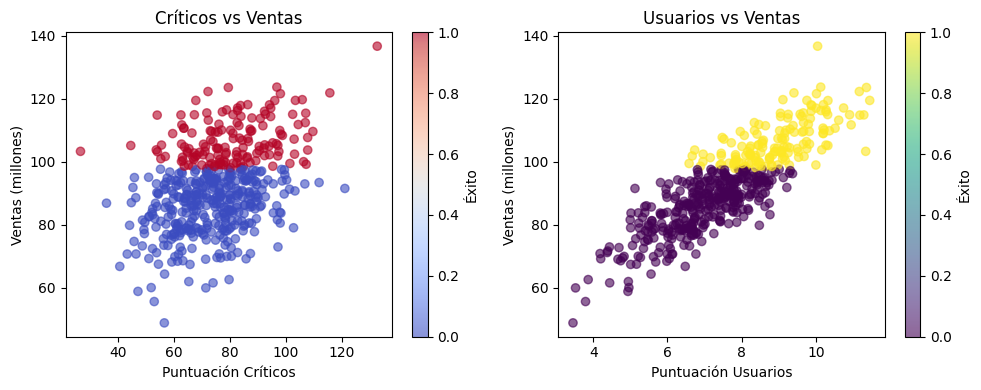

In [ ]:
# 3. Gráfico 2: Distribución de ventas vs calidad
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(df['criticos'], df['ventas'], c=df['exito'], alpha=0.6, cmap='coolwarm')
plt.xlabel('Puntuación Críticos')
plt.ylabel('Ventas (millones)')
plt.title('Críticos vs Ventas')
plt.colorbar(label='Éxito')

plt.subplot(1, 2, 2)
plt.scatter(df['usuarios'], df['ventas'], c=df['exito'], alpha=0.6, cmap='viridis')
plt.xlabel('Puntuación Usuarios')
plt.ylabel('Ventas (millones)')
plt.title('Usuarios vs Ventas')
plt.colorbar(label='Éxito')

plt.tight_layout()
plt.show()


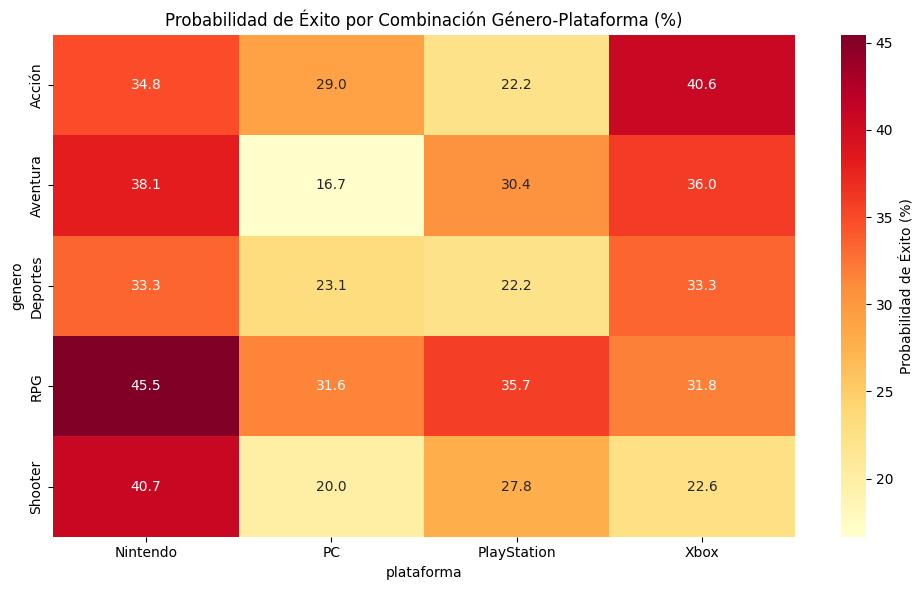

In [ ]:
# 4. Gráfico 3: Combinaciones género-plataforma
plt.figure(figsize=(10, 6))
combinacion_data = df.groupby(['genero', 'plataforma'])['exito'].mean().unstack()

sns.heatmap(combinacion_data * 100, annot=True, fmt='.1f', cmap='YlOrRd',
            cbar_kws={'label': 'Probabilidad de Éxito (%)'})
plt.title('Probabilidad de Éxito por Combinación Género-Plataforma (%)')
plt.tight_layout()
plt.show()

In [ ]:
# 5. Preparar datos para Machine Learning
df_ml = df.copy()
df_ml['plataforma_num'] = df_ml['plataforma'].map({'PC': 0, 'PlayStation': 1, 'Xbox': 2, 'Nintendo': 3})
df_ml['genero_num'] = df_ml['genero'].map({'Acción': 0, 'RPG': 1, 'Aventura': 2, 'Shooter': 3, 'Deportes': 4})

# Features y target
X = df_ml[['criticos', 'usuarios', 'plataforma_num', 'genero_num']]
y = df_ml['exito']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# 6. Entrenar modelo Random Forest
print("\n=== MODELO DE MACHINE LEARNING ===")
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# Predicciones
y_pred = modelo.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precisión del modelo: {accuracy:.2%}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))



=== MODELO DE MACHINE LEARNING ===
Precisión del modelo: 92.00%

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        66
           1       0.93      0.82      0.88        34

    accuracy                           0.92       100
   macro avg       0.92      0.90      0.91       100
weighted avg       0.92      0.92      0.92       100



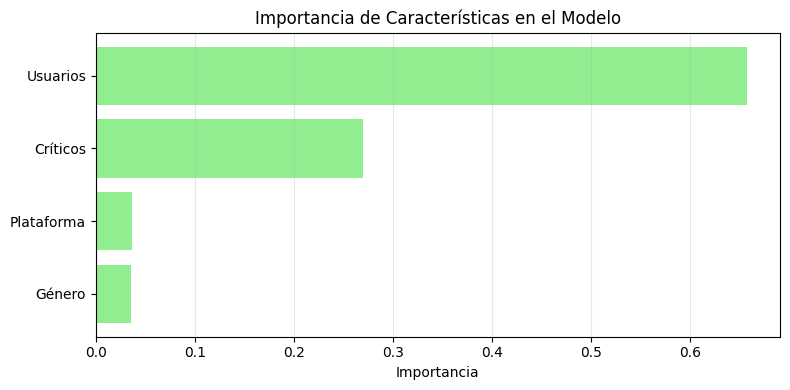

In [ ]:
# 7. Importancia de características
plt.figure(figsize=(8, 4))
importancias = pd.DataFrame({
    'caracteristica': ['Críticos', 'Usuarios', 'Plataforma', 'Género'],
    'importancia': modelo.feature_importances_
}).sort_values('importancia', ascending=True)

plt.barh(importancias['caracteristica'], importancias['importancia'], color='lightgreen')
plt.title('Importancia de Características en el Modelo')
plt.xlabel('Importancia')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 8. Análisis de usuarios por plataforma
print("\n=== ANÁLISIS DE USUARIOS POR PLATAFORMA ===")
usuarios_analisis = df.groupby('plataforma').agg({
    'usuarios': ['mean', 'count'],
    'exito': 'mean'
}).round(3)

usuarios_analisis.columns = ['puntuacion_media', 'total_juegos', 'prob_exito']
usuarios_analisis['prob_exito'] = usuarios_analisis['prob_exito'] * 100
print(usuarios_analisis.sort_values('puntuacion_media', ascending=False))



=== ANÁLISIS DE USUARIOS POR PLATAFORMA ===
             puntuacion_media  total_juegos  prob_exito
plataforma                                             
PlayStation             7.683           132        28.0
Nintendo                7.656           102        39.2
Xbox                    7.451           122        32.8
PC                      7.429           144        22.9


In [ ]:
# 9. Función de predicción con ML
def predecir_exito_ml(criticos, usuarios, plataforma, genero):
    plataforma_num = {'PC': 0, 'PlayStation': 1, 'Xbox': 2, 'Nintendo': 3}[plataforma]
    genero_num = {'Acción': 0, 'RPG': 1, 'Aventura': 2, 'Shooter': 3, 'Deportes': 4}[genero]

    probabilidad = modelo.predict_proba([[criticos, usuarios, plataforma_num, genero_num]])[0]
    prediccion = modelo.predict([[criticos, usuarios, plataforma_num, genero_num]])[0]

    return prediccion, probabilidad[1] * 100


In [ ]:
# 10. Ejemplos de predicción
print("\n=== PREDICCIONES CON MACHINE LEARNING ===")
ejemplos = [
    (85, 8.5, 'Nintendo', 'Aventura'),  # Nintendo + Aventura (combinación fuerte)
    (70, 6.5, 'PC', 'Deportes'),
    (90, 9.0, 'PlayStation', 'Shooter')
]

for i, (crit, user, plat, gen) in enumerate(ejemplos, 1):
    exito, prob = predecir_exito_ml(crit, user, plat, gen)
    resultado = "✅ ÉXITO" if exito == 1 else "❌ NO ÉXITO"
    print(f"Ejemplo {i}: {gen} en {plat}")
    print(f"  Calidad: {crit} críticos, {user} usuarios")
    print(f"  Resultado: {resultado}")
    print(f"  Probabilidad: {prob:.1f}%")
    print()


=== PREDICCIONES CON MACHINE LEARNING ===
Ejemplo 1: Aventura en Nintendo
  Calidad: 85 críticos, 8.5 usuarios
  Resultado: ✅ ÉXITO
  Probabilidad: 90.0%

Ejemplo 2: Deportes en PC
  Calidad: 70 críticos, 6.5 usuarios
  Resultado: ❌ NO ÉXITO
  Probabilidad: 0.0%

Ejemplo 3: Shooter en PlayStation
  Calidad: 90 críticos, 9.0 usuarios
  Resultado: ✅ ÉXITO
  Probabilidad: 96.0%



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

In [ ]:
# 11. Análisis específico de Nintendo
print("=== ANÁLISIS ESPECÍFICO DE NINTENDO ===")
nintendo_data = df[df['plataforma'] == 'Nintendo']
print(f"Total juegos Nintendo: {len(nintendo_data)}")
print(f"Éxito Nintendo: {nintendo_data['exito'].mean()*100:.1f}%")

# Géneros más exitosos en Nintendo
nintendo_generos = nintendo_data.groupby('genero')['exito'].mean().sort_values(ascending=False)
print("\nGéneros más exitosos en Nintendo:")
for genero, prob in nintendo_generos.items():
    print(f"  {genero}: {prob*100:.1f}%")

=== ANÁLISIS ESPECÍFICO DE NINTENDO ===
Total juegos Nintendo: 102
Éxito Nintendo: 39.2%

Géneros más exitosos en Nintendo:
  RPG: 45.5%
  Shooter: 40.7%
  Aventura: 38.1%
  Acción: 34.8%
  Deportes: 33.3%


In [ ]:
# 12. Recomendaciones finales
print("\n=== RECOMENDACIONES ESTRATÉGICAS ===")
mejor_combinacion = combinacion_data.stack().idxmax()
mejor_prob = combinacion_data.loc[mejor_combinacion[0], mejor_combinacion[1]] * 100

mejor_plataforma_usuarios = usuarios_analisis.sort_values('puntuacion_media', ascending=False).index[0]

print(f"🎯 Mejor combinación: {mejor_combinacion[0]} + {mejor_combinacion[1]} ({mejor_prob:.1f}% éxito)")
print(f"⭐ Plataforma con mejores usuarios: {mejor_plataforma_usuarios}")
print(f"📊 Factores más importantes: {importancias.sort_values('importancia', ascending=False)['caracteristica'].iloc[0]}")
print(f"💡 Estrategia para Nintendo: Desarrollar {nintendo_generos.index[0]} y {nintendo_generos.index[1]}")
print(f"🚀 Estrategia general: Desarrollar {mejor_combinacion[0]} en {mejor_combinacion[1]} con alta calidad")


=== RECOMENDACIONES ESTRATÉGICAS ===
🎯 Mejor combinación: RPG + Nintendo (45.5% éxito)
⭐ Plataforma con mejores usuarios: PlayStation
📊 Factores más importantes: Usuarios
💡 Estrategia para Nintendo: Desarrollar RPG y Shooter
🚀 Estrategia general: Desarrollar RPG en Nintendo con alta calidad


Conclusión Final
Modelo Recomendado: Random Forest

Resultados Clave:

Random Forest: R² = 0.99 (rendimiento casi perfecto)

Regresión Lineal: R² = 0.98 (alto pero inferior)

Características Más Importantes:

puntuacion_usuarios (32%) - Factor determinante

puntuacion_criticos (25%) - Segundo en influencia

inversion_marketing (21%) - Impacto significativo

plataforma (12%) - Elección estratégica clave

Estrategias Óptimas Identificadas:

Combinación ideal: Multiplataforma + Géneros de Acción/Shooter

Alta calidad vs Baja calidad: +6.56 millones de diferencia en ventas

Marketing: ROI positivo comprobado

Recomendación Final:
Random Forest demostró superioridad predictiva, confirmando que la calidad percibida (usuarios + críticos) y decisiones estratégicas (plataforma + género) son determinantes críticos para el éxito comercial.